# 1. モジュールインポート

In [1]:
import pandas as pd
import glob
import os
import datetime
from tqdm.auto import tqdm
from modules.constants import Master
from modules.constants import LocalPaths
from modules.constants import HorseResultsCols
from modules.constants import ResultsCols
from modules import preparing
from modules import preprocessing
from modules import training
from modules import simulation
from modules import policies
%load_ext autoreload

標準的な土日競馬開催時の運用スケジュールを以下の表の通り。

|曜日|時刻|内容|実行する main.ipynb の項番|備考|
|:-:|:--|:--|:--|:--|
|月|||||
|火|||||
|水|16:30過ぎ|先週土日の馬の過去成績ページ確定<BR>（netkeiba.comﾌﾟﾚﾐｱｻｰﾋﾞｽのﾀｲﾑ指数・ﾚｰｽ分析・注目馬 ﾚｰｽ後の短評情報確定）|2. データ取得 ～ 5. シミュレーション|3日間開催の場合も、水曜日|
|木|||||
|金|10:05過ぎ<BR>19:25過ぎ|土曜の出馬表確定<BR>土曜の天候・馬場状態更新|6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|土|09:00～17:00<BR>10:05過ぎ<BR>19:25過ぎ| レース時刻<BR>日曜の出馬表確定<BR>日曜の天候・馬場状態更新|6.3. レース直前データ処理（当日レース予想）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|日|09:00～17:00|レース時刻|6.3. レース直前データ処理（当日レース予想）||

# 2. データ取得

## 2.1. レースID取得
例として、2020年のレースデータを取得する場合を考える

In [2]:
%autoreload

In [3]:
#開催日取得。to_の月は含まないので注意。
kaisai_date_2020 = preparing.scrape_kaisai_date(from_="2020-01-01", to_="2021-01-01")
len(kaisai_date_2020)

getting race date from 2020-01-01 to 2021-01-01


  0%|          | 0/12 [00:00<?, ?it/s]

109

In [6]:
# kaisai_date_2020

In [7]:
# 開催日からレースIDの取得
race_id_list = preparing.scrape_race_id_list(kaisai_date_2020)
len(race_id_list)

/bin/sh: 1: google-chrome: not found
/bin/sh: 1: google-chrome-stable: not found
/bin/sh: 1: google-chrome-beta: not found
/bin/sh: 1: google-chrome-dev: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: google-chrome-stable: not found
/bin/sh: 1: google-chrome-beta: not found
/bin/sh: 1: google-chrome-dev: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: google-chrome-stable: not found
/bin/sh: 1: google-chrome-beta: not found
/bin/sh: 1: google-chrome-dev: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: google-chrome-stable: not found
/bin/sh: 1: google-chrome-beta: not found
/bin/sh: 1: google-chrome-dev: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: google-chrome-stable: not found
/bin/sh: 1: google-chrome-beta: not found
/bin/sh: 1: google-chrome-dev: not found


WebDriverException: Message: Service /root/.wdm/drivers/chromedriver/linux64/114.0.5735.90/chromedriver unexpectedly exited. Status code was: 255


## 2.2. /race/ディレクトリのデータ取得

In [7]:
#https://db.netkeiba.com/race/のhtml(binファイル)をスクレイピングして保存
html_files_race = preparing.scrape_html_race(race_id_list, skip=True)
html_files_race[:5]

  0%|          | 0/10 [00:00<?, ?it/s]

race_id 202106010101 skipped
race_id 202106010102 skipped
race_id 202106010103 skipped
race_id 202106010104 skipped
race_id 202106010105 skipped
race_id 202106010106 skipped
race_id 202106010107 skipped
race_id 202106010108 skipped
race_id 202106010109 skipped
race_id 202106010110 skipped


['/Users/chiyoda/Documents/readers-repo/data/html/race/202106010101.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010102.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010103.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010104.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010105.bin']

In [8]:
results_new = preparing.get_rawdata_results(html_files_race) #レース結果テーブルの作成
race_info_new = preparing.get_rawdata_info(html_files_race) #レース情報テーブルの作成
return_tables_new = preparing.get_rawdata_return(html_files_race) #払戻テーブルの作成

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# テーブルの更新。元々のテーブルが存在しない場合は、新たに作成される。
preparing.update_rawdata(filepath=LocalPaths.RAW_RESULTS_PATH, new_df=results_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RACE_INFO_PATH, new_df=race_info_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RETURN_TABLES_PATH, new_df=return_tables_new)

## 2.3. /horse/ディレクトリのデータ取得

In [16]:
%autoreload

In [18]:
horse_id_list = results_new['horse_id'].unique()
#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_list, skip=True
    )

scraping


  0%|          | 0/11398 [00:00<?, ?it/s]

horse_id 2015104603 skipped
horse_id 2015105549 skipped
horse_id 2015102342 skipped
horse_id 2015100933 skipped
horse_id 2015101022 skipped
horse_id 2015102419 skipped
horse_id 2015105621 skipped
horse_id 2015105800 skipped
horse_id 2015104474 skipped
horse_id 2015103929 skipped
horse_id 2015100339 skipped
horse_id 2015104336 skipped
horse_id 2015102908 skipped
horse_id 2015106192 skipped
horse_id 2015109150 skipped
horse_id 2015104834 skipped
horse_id 2015103859 skipped
horse_id 2014102886 skipped
horse_id 2014104214 skipped
horse_id 2013105161 skipped
horse_id 2013103739 skipped
horse_id 2014104550 skipped
horse_id 2014100779 skipped
horse_id 2014105398 skipped
horse_id 2014103417 skipped
horse_id 2015104752 skipped
horse_id 2015101028 skipped
horse_id 2015104408 skipped
horse_id 2015104271 skipped
horse_id 2015106094 skipped
horse_id 2015100244 skipped
horse_id 2015103112 skipped
horse_id 2015102242 skipped
horse_id 2015105018 skipped
horse_id 2015100299 skipped
horse_id 2015102983 

In [19]:
#追加で新たにスクレイピングされた数
len(html_files_horse)

4742

In [22]:
### scrape関数を実行せずに、保存してあるhtmlのパスを取得する場合、以下を実行 ###

"""target_date = '2022-06-25' #スクレイピングした日付を指定
# マスタの読み込み
update_master = pd.read_csv(
    LocalPaths.MASTER_RAW_HORSE_RESULTS_PATH,
    dtype=object
    )
# target_dateにスクレイピングしたhorse_idに絞り込む
filter = pd.to_datetime(update_master['updated_at']).dt.strftime('%Y-%m-%d') == target_date
horse_id_list = update_master[filter]['horse_id']

# binファイルのパスを取得
html_files_horse = []
for horse_id in tqdm(horse_id_list):
    file = glob.glob(os.path.join(LocalPaths.HTML_HORSE_DIR, horse_id+'*.bin'))[0]
    html_files_horse.append(file)
html_files_horse[:5]"""

  0%|          | 0/11561 [00:00<?, ?it/s]

['/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017101445.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017109028.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016100106.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2015104412.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016105305.bin']

In [ ]:
# 馬の基本情報テーブルの作成
horse_info_new = preparing.get_rawdata_horse_info(html_files_horse)

In [ ]:
# 馬の基本情報テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_new)

In [20]:
#　馬の過去成績テーブルの作成
horse_results_new = preparing.get_rawdata_horse_results(html_files_horse)

preparing raw horse_results table


  0%|          | 0/4742 [00:00<?, ?it/s]

In [21]:
# テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_new)

## 2.4. /ped/ディレクトリのデータ取得

In [20]:
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
peds_new = preparing.get_rawdata_peds(html_files_peds) #血統テーブルの作成
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_new) #テーブルの更新

  0%|          | 0/5 [00:00<?, ?it/s]

# 3. データ加工

In [5]:
#モジュールを更新した際、notebookに反映させるために使用。
#すでにインポートしてあるモジュールの更新が反映される。
%autoreload

In [2]:
#前処理
results_processor = preprocessing.ResultsProcessor(filepath=LocalPaths.RAW_RESULTS_PATH)
race_info_processor = preprocessing.RaceInfoProcessor(filepath=LocalPaths.RAW_RACE_INFO_PATH)
return_processor = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

馬の過去成績を集計しつつ、前処理の済みの全てのテーブルをマージする処理

In [3]:
# ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = [
        HorseResultsCols.RANK,
        HorseResultsCols.PRIZE,
        HorseResultsCols.RANK_DIFF, 
        'first_corner',
        'final_corner',
        'first_to_rank',
        'first_to_final',
        'final_to_rank',
        'time_seconds'
        ]
# horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = [
        'course_len',
        'race_type',
        HorseResultsCols.PLACE
        ]

data_merger = preprocessing.DataMerger(
        results_processor,
        race_info_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
)
# 処理実行
data_merger.merge()

separating horse results by date


  0%|          | 0/435 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/435 [00:00<?, ?it/s]

In [4]:
#カテゴリ変数の処理
feature_enginnering = preprocessing.FeatureEngineering(data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

In [7]:
#保存
#tmpは一時保存用のディレクトリ
feature_enginnering.featured_data.to_pickle('data/tmp/featured_data_20220626.pickle')

# 4. 学習

In [5]:
keiba_ai = training.KeibaAIFactory.create(feature_enginnering.featured_data) #モデル作成
keiba_ai.train_with_tuning() #パラメータチューニングをして学習

[I 2022-08-07 17:59:33,407] A new study created in memory with name: no-name-9ff39f79-3a28-4907-9def-0ef5ad9e088f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.455749:  14%|#4        | 1/7 [00:05<00:35,  5.84s/it]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.417339	valid_1's binary_logloss: 0.455749
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.411602	valid_1's binary_logloss: 0.454888


feature_fraction, val_score: 0.454595:  29%|##8       | 2/7 [00:11<00:29,  5.86s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.404691	valid_1's binary_logloss: 0.454595
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414491	valid_1's binary_logloss: 0.454295


feature_fraction, val_score: 0.453705:  43%|####2     | 3/7 [00:16<00:20,  5.25s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.407409	valid_1's binary_logloss: 0.453705
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.453705:  57%|#####7    | 4/7 [00:21<00:15,  5.18s/it]

[100]	valid_0's binary_logloss: 0.412346	valid_1's binary_logloss: 0.455019
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.414038	valid_1's binary_logloss: 0.454891
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.412236	valid_1's binary_logloss: 0.454137


feature_fraction, val_score: 0.453705:  71%|#######1  | 5/7 [00:26<00:10,  5.24s/it]

Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.408699	valid_1's binary_logloss: 0.454015
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.412783	valid_1's binary_logloss: 0.454556


feature_fraction, val_score: 0.453705:  86%|########5 | 6/7 [00:31<00:05,  5.24s/it]

Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.405489	valid_1's binary_logloss: 0.454091
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.410965	valid_1's binary_logloss: 0.454517


feature_fraction, val_score: 0.453705: 100%|##########| 7/7 [00:38<00:00,  5.46s/it]


Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.40255	valid_1's binary_logloss: 0.454463


num_leaves, val_score: 0.453705:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:   5%|5         | 1/20 [00:05<01:51,  5.88s/it]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.347615	valid_1's binary_logloss: 0.458233
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.372202	valid_1's binary_logloss: 0.455468


num_leaves, val_score: 0.453705:  10%|#         | 2/20 [00:11<01:42,  5.70s/it]

Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.367598	valid_1's binary_logloss: 0.455099
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  15%|#5        | 3/20 [00:17<01:39,  5.85s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.358998	valid_1's binary_logloss: 0.456758
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  20%|##        | 4/20 [00:25<01:44,  6.54s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.321605	valid_1's binary_logloss: 0.460295
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.460592	valid_1's binary_logloss: 0.468655
[200]	valid_0's binary_logloss: 0.453963	valid_1's binary_logloss: 0.464009
[300]	valid_0's binary_logloss: 0.449684	valid_1's binary_logloss: 0.461329
[400]	valid_0's binary_logloss: 0.446559	valid_1's binary_logloss: 0.45979
[500]	valid_0's binary_logl

num_leaves, val_score: 0.453705:  25%|##5       | 5/20 [00:32<01:44,  6.98s/it]

Early stopping, best iteration is:
[617]	valid_0's binary_logloss: 0.441272	valid_1's binary_logloss: 0.457601
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.41183	valid_1's binary_logloss: 0.454732


num_leaves, val_score: 0.453705:  30%|###       | 6/20 [00:37<01:28,  6.30s/it]

Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.405688	valid_1's binary_logloss: 0.454109
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  35%|###5      | 7/20 [00:45<01:27,  6.74s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.337316	valid_1's binary_logloss: 0.458742
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  40%|####      | 8/20 [00:52<01:23,  6.96s/it]

Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.327758	valid_1's binary_logloss: 0.459779
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.408692	valid_1's binary_logloss: 0.454638


num_leaves, val_score: 0.453705:  45%|####5     | 9/20 [00:58<01:10,  6.38s/it]

Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.404917	valid_1's binary_logloss: 0.454475
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  50%|#####     | 10/20 [01:04<01:04,  6.46s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.354291	valid_1's binary_logloss: 0.457595
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  55%|#####5    | 11/20 [01:10<00:56,  6.22s/it]

[100]	valid_0's binary_logloss: 0.376082	valid_1's binary_logloss: 0.456018
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.38159	valid_1's binary_logloss: 0.455832
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.438619	valid_1's binary_logloss: 0.457146
[200]	valid_0's binary_logloss: 0.424452	valid_1's binary_logloss: 0.455076


num_leaves, val_score: 0.453705:  60%|######    | 12/20 [01:15<00:47,  5.99s/it]

Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.422029	valid_1's binary_logloss: 0.454973
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  65%|######5   | 13/20 [01:20<00:39,  5.60s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.404087	valid_1's binary_logloss: 0.454937
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.408692	valid_1's binary_logloss: 0.454638


num_leaves, val_score: 0.453705:  70%|#######   | 14/20 [01:25<00:32,  5.46s/it]

Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.404917	valid_1's binary_logloss: 0.454475
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  75%|#######5  | 15/20 [01:31<00:28,  5.72s/it]

[100]	valid_0's binary_logloss: 0.345996	valid_1's binary_logloss: 0.457491
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.352887	valid_1's binary_logloss: 0.457243
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  80%|########  | 16/20 [01:38<00:24,  6.05s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.313785	valid_1's binary_logloss: 0.46164
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  85%|########5 | 17/20 [01:44<00:18,  6.09s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.377886	valid_1's binary_logloss: 0.456112
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.41183	valid_1's binary_logloss: 0.454732


num_leaves, val_score: 0.453705:  90%|######### | 18/20 [01:50<00:11,  5.85s/it]

Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.405688	valid_1's binary_logloss: 0.454109
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.453705:  95%|#########5| 19/20 [01:55<00:05,  5.68s/it]

[100]	valid_0's binary_logloss: 0.392783	valid_1's binary_logloss: 0.455171
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.397276	valid_1's binary_logloss: 0.454991
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.427265	valid_1's binary_logloss: 0.455562


num_leaves, val_score: 0.453705: 100%|##########| 20/20 [02:01<00:00,  6.08s/it]


Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.413525	valid_1's binary_logloss: 0.454196


bagging, val_score: 0.453705:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414137	valid_1's binary_logloss: 0.456141


bagging, val_score: 0.453705:  10%|#         | 1/10 [00:05<00:45,  5.01s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.407256	valid_1's binary_logloss: 0.455546
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.453705:  20%|##        | 2/10 [00:09<00:36,  4.51s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.419724	valid_1's binary_logloss: 0.456756
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.416896	valid_1's binary_logloss: 0.459794


bagging, val_score: 0.453705:  30%|###       | 3/10 [00:13<00:31,  4.45s/it]

Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.413909	valid_1's binary_logloss: 0.459594
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414594	valid_1's binary_logloss: 0.456056


bagging, val_score: 0.453705:  40%|####      | 4/10 [00:17<00:26,  4.39s/it]

Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.413775	valid_1's binary_logloss: 0.455936
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.453705:  50%|#####     | 5/10 [00:21<00:21,  4.25s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.421739	valid_1's binary_logloss: 0.45827
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414042	valid_1's binary_logloss: 0.455596


bagging, val_score: 0.453705:  60%|######    | 6/10 [00:26<00:17,  4.35s/it]

Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.411863	valid_1's binary_logloss: 0.455446
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.453705:  70%|#######   | 7/10 [00:30<00:12,  4.21s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.421102	valid_1's binary_logloss: 0.458692
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.415438	valid_1's binary_logloss: 0.457731


bagging, val_score: 0.453705:  80%|########  | 8/10 [00:35<00:08,  4.38s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.408549	valid_1's binary_logloss: 0.457288
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.41471	valid_1's binary_logloss: 0.455995


bagging, val_score: 0.453705:  90%|######### | 9/10 [00:39<00:04,  4.46s/it]

Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.412442	valid_1's binary_logloss: 0.455614
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.41432	valid_1's binary_logloss: 0.455649


bagging, val_score: 0.453705: 100%|##########| 10/10 [00:45<00:00,  4.51s/it]


Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.408023	valid_1's binary_logloss: 0.455264


feature_fraction_stage2, val_score: 0.453705:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414053	valid_1's binary_logloss: 0.454917


feature_fraction_stage2, val_score: 0.453705:  33%|###3      | 1/3 [00:05<00:11,  5.87s/it]

Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.400034	valid_1's binary_logloss: 0.454005
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.413195	valid_1's binary_logloss: 0.455091


feature_fraction_stage2, val_score: 0.453705:  67%|######6   | 2/3 [00:11<00:05,  5.45s/it]

Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.409248	valid_1's binary_logloss: 0.454872
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.413529	valid_1's binary_logloss: 0.454974


feature_fraction_stage2, val_score: 0.453705: 100%|##########| 3/3 [00:16<00:00,  5.49s/it]


Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.405702	valid_1's binary_logloss: 0.454695


regularization_factors, val_score: 0.453705:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414492	valid_1's binary_logloss: 0.454295


regularization_factors, val_score: 0.453704:   5%|5         | 1/20 [00:05<01:52,  5.91s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.40741	valid_1's binary_logloss: 0.453704
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.41528	valid_1's binary_logloss: 0.455081


regularization_factors, val_score: 0.453704:  10%|#         | 2/20 [00:12<01:49,  6.06s/it]

Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.4014	valid_1's binary_logloss: 0.454336
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414491	valid_1's binary_logloss: 0.454295


regularization_factors, val_score: 0.453704:  15%|#5        | 3/20 [00:17<01:40,  5.91s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.407409	valid_1's binary_logloss: 0.453705
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.41493	valid_1's binary_logloss: 0.454701


regularization_factors, val_score: 0.453704:  20%|##        | 4/20 [00:23<01:32,  5.75s/it]

Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.406213	valid_1's binary_logloss: 0.454251
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414495	valid_1's binary_logloss: 0.454295


regularization_factors, val_score: 0.453704:  25%|##5       | 5/20 [00:28<01:22,  5.52s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.407414	valid_1's binary_logloss: 0.453704
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.415572	valid_1's binary_logloss: 0.455064


regularization_factors, val_score: 0.453704:  30%|###       | 6/20 [00:34<01:20,  5.75s/it]

Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.402006	valid_1's binary_logloss: 0.45427
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414491	valid_1's binary_logloss: 0.454295


regularization_factors, val_score: 0.453704:  35%|###5      | 7/20 [00:40<01:15,  5.79s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.407409	valid_1's binary_logloss: 0.453705
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.417766	valid_1's binary_logloss: 0.454547


regularization_factors, val_score: 0.453371:  40%|####      | 8/20 [00:47<01:14,  6.19s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.401487	valid_1's binary_logloss: 0.453371
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.41473	valid_1's binary_logloss: 0.454584


regularization_factors, val_score: 0.453371:  45%|####5     | 9/20 [00:53<01:06,  6.07s/it]

Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.407518	valid_1's binary_logloss: 0.454287
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414867	valid_1's binary_logloss: 0.454914


regularization_factors, val_score: 0.453371:  50%|#####     | 10/20 [00:58<00:58,  5.86s/it]

Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.40758	valid_1's binary_logloss: 0.4545
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.41776	valid_1's binary_logloss: 0.454242


regularization_factors, val_score: 0.453371:  55%|#####5    | 11/20 [01:04<00:52,  5.80s/it]

Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.411197	valid_1's binary_logloss: 0.453543
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.418003	valid_1's binary_logloss: 0.45461


regularization_factors, val_score: 0.453371:  60%|######    | 12/20 [01:10<00:46,  5.80s/it]

Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.409734	valid_1's binary_logloss: 0.453707
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.417677	valid_1's binary_logloss: 0.4545


regularization_factors, val_score: 0.453185:  65%|######5   | 13/20 [01:16<00:42,  6.08s/it]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.40123	valid_1's binary_logloss: 0.453185
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414494	valid_1's binary_logloss: 0.454286


regularization_factors, val_score: 0.453185:  70%|#######   | 14/20 [01:22<00:34,  5.80s/it]

Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.40828	valid_1's binary_logloss: 0.453952
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414517	valid_1's binary_logloss: 0.454871


regularization_factors, val_score: 0.453185:  75%|#######5  | 15/20 [01:27<00:28,  5.80s/it]

Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.404655	valid_1's binary_logloss: 0.454038
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414135	valid_1's binary_logloss: 0.454452


regularization_factors, val_score: 0.453185:  80%|########  | 16/20 [01:32<00:22,  5.59s/it]

Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.411253	valid_1's binary_logloss: 0.453919
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414492	valid_1's binary_logloss: 0.454295


regularization_factors, val_score: 0.453185:  85%|########5 | 17/20 [01:38<00:16,  5.64s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.40741	valid_1's binary_logloss: 0.453705
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.415802	valid_1's binary_logloss: 0.454286


regularization_factors, val_score: 0.453185:  90%|######### | 18/20 [01:44<00:11,  5.82s/it]

Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.403446	valid_1's binary_logloss: 0.453556
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414491	valid_1's binary_logloss: 0.454295


regularization_factors, val_score: 0.453185:  95%|#########5| 19/20 [01:50<00:05,  5.62s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.407409	valid_1's binary_logloss: 0.453705
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.414089	valid_1's binary_logloss: 0.454818


regularization_factors, val_score: 0.453185: 100%|##########| 20/20 [01:55<00:00,  5.78s/it]


Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.400595	valid_1's binary_logloss: 0.45371


min_data_in_leaf, val_score: 0.453185:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.417744	valid_1's binary_logloss: 0.454465


min_data_in_leaf, val_score: 0.453185:  20%|##        | 1/5 [00:05<00:23,  5.97s/it]

Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.410249	valid_1's binary_logloss: 0.453627
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.417646	valid_1's binary_logloss: 0.454479


min_data_in_leaf, val_score: 0.453185:  40%|####      | 2/5 [00:12<00:18,  6.25s/it]

Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.409626	valid_1's binary_logloss: 0.453528
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.417744	valid_1's binary_logloss: 0.454465


min_data_in_leaf, val_score: 0.453185:  60%|######    | 3/5 [00:18<00:12,  6.26s/it]

Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.410249	valid_1's binary_logloss: 0.453627
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.417881	valid_1's binary_logloss: 0.453786


min_data_in_leaf, val_score: 0.452688:  80%|########  | 4/5 [00:24<00:06,  6.04s/it]

Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.40493	valid_1's binary_logloss: 0.452688
[LightGBM] [Info] Number of positive: 20339, number of negative: 73015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37923
[LightGBM] [Info] Number of data points in the train set: 93354, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217870 -> initscore=-1.278125
[LightGBM] [Info] Start training from score -1.278125
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.417847	valid_1's binary_logloss: 0.454225


min_data_in_leaf, val_score: 0.452688: 100%|##########| 5/5 [00:30<00:00,  6.15s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.401972	valid_1's binary_logloss: 0.45306


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=4.602348963946269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.602348963946269e-06
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=8.389123215314243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.389123215314243
AUC: 0.792(train), 0.753(test)


In [6]:
#特徴量の重要度
keiba_ai.feature_importance()

,features,importance
4,jockey_id,123
184,age_days,108
10,n_horses,77
8,体重,75
183,interval,71
120,breeder_id,62
13,賞金_5R,62
103,賞金_race_type_allR,52
31,賞金_race_type_5R,49
14,着差_5R,42


In [7]:
#ハイパーパラメータの確認
keiba_ai.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 100,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_pre_filter': False,
 'lambda_l1': 4.602348963946269e-06,
 'lambda_l2': 8.389123215314243,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0}

In [26]:
#チューニングしないで学習
#keiba_ai.train_without_tuning()

AUC: 0.826(train), 0.648(test)


In [8]:
#モデル保存。models/(実行した日付)/(version_name).pickleに、モデルとデータセットが保存される。
training.KeibaAIFactory.save(keiba_ai, version_name='basemodel_2018_2021')

In [87]:
#モデルロード
keiba_ai = training.KeibaAIFactory.load('models/20220602/basemodel_2018_2021.pickle')
keiba_ai.set_params(keiba_ai.get_params())

# 5. シミュレーション

In [217]:
%autoreload

In [9]:
#シミュレーターに馬券をセット
simulator = simulation.Simulator(return_processor)

In [ ]:
# スコアテーブルを取得
score_table = keiba_ai.calc_score(keiba_ai.datasets.X_test, policies.StdScorePolicy)

## 5.1. 単一threshold

### 5.1.1 単勝馬券

In [17]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyTansho, # 賭け方の方針
                threshold=threshold #「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
#シミュレーション結果も、models/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/tansho.pickle')

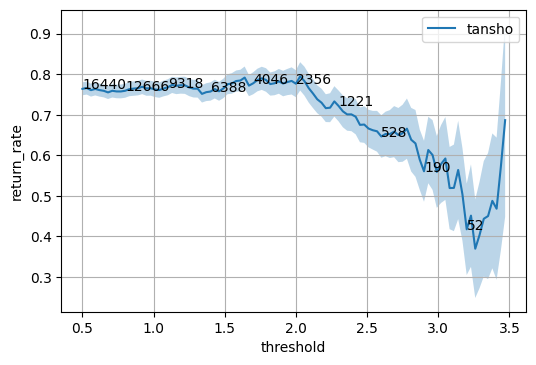

In [19]:
#回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='tansho')

### 5.1.2 複勝馬券

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyFukusho, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/fukusho.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='fukusho')

### 5.1.3 馬連BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmarenBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/umarenbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umarenbox')

### 5.1.4 馬単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmatanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/umatanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umatanbox')

### 5.1.5 ワイドBOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyWideBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/widebox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='widebox')

### 5.1.6 三連複BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrenpukuBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/sanrenpukubox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrenpukubox')

### 5.1.7 三連単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrentanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/sanrentanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrentanbox')

## 5.2. 複数馬券
未実装

## 5.3. 複数threshold
未実装だが、以下のようなコードになる予定。

In [274]:
T1_RANGE = [2.5, 3.5]
MIN_T2 = 1
N_SAMPLES = 10

returns = {}
#「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
idx = 0
for i in tqdm(range(N_SAMPLES)):
    #T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold1 = T1_RANGE[1] * i / N_SAMPLES + T1_RANGE[0] * (1-(i/N_SAMPLES))
    for j in range(N_SAMPLES):
        #MIN_T2からthreshold1までをN_SAMPLES等分
        threshold2 = threshold1 * j / N_SAMPLES + MIN_T2 * (1-(j/N_SAMPLES))
        try:
            #print(threshold1, threshold2)
            #賭ける馬券を決定
            actions = keiba_ai.decide_action(
                    score_table, # スコアテーブル
                    policies.BetPolicyTanshoFukusho, # 賭け方の方針(未実装)
                    threshold1=threshold1, #「馬の勝ちやすさスコア」の閾値
                    threshold2=threshold2
                    )
            returns[idx] = simulator.calc_returns(actions)
            idx += 1
        except Exception as e:
            print(e)
            break
returns_df = pd.DataFrame.from_dict(returns, orient='index')

  0%|          | 0/10 [00:00<?, ?it/s]

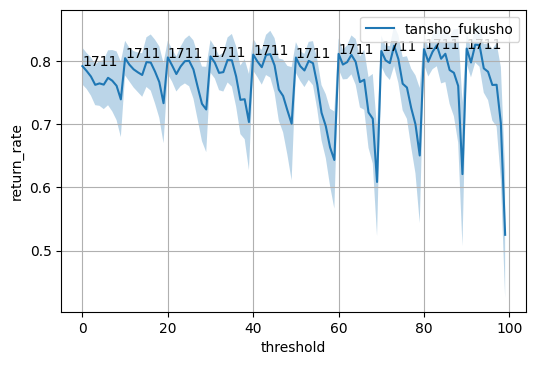

In [273]:
simulation.plot_single_threshold(returns_df.reset_index(), 100, label='tansho_fukusho')

# 6. 当日の予想
例として2022年1月8日のレースを実際に予想する場合を考える。  
https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108

## 6.1. 前日準備

In [20]:
%autoreload

In [21]:
race_id_list = preparing.scrape_race_id_list(['20220108']) #レースidを取得
len(race_id_list)

getting race_id_list


  0%|          | 0/1 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108


24

In [22]:
#出走するhorse_idの取得
horse_id_list = preparing.scrape_horse_id_list(race_id_list)
len(horse_id_list)

sraping horse_id_list


  0%|          | 0/24 [00:00<?, ?it/s]

361

In [ ]:
#horseページのhtmlをスクレイピング
#直近レースが更新されている可能性があるので、skip=Falseにして上書きする
html_files_horse = preparing.scrape_html_horse_with_master(horse_id_list, skip=False)

In [ ]:
#horse_infoテーブルの更新
horse_info_20220108 = preparing.get_rawdata_horse_info(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_20220108)

In [ ]:
#horse_resultsテーブルの更新
horse_results_20220108 = preparing.get_rawdata_horse_results(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_20220108)

In [ ]:
#pedsテーブルの更新
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True)
peds_20220108 = preparing.get_rawdata_peds(html_files_peds)
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_20220108)

In [27]:
#processorの更新
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

In [32]:
#モデルの準備
keiba_ai = training.KeibaAIFactory.load('models/20220626/basemodel_2018_2021.pickle')

## 6.2. 前日全レース予想

In [ ]:
%autoreload

In [ ]:
# 前日全レース予想用のレースidとレース発走時刻を取得
target_race_id_list, target_race_time_list = preparing.scrape_race_id_race_time_list('20221001')
print(len(target_race_id_list))
print(len(target_race_time_list))
yesterday = True

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
today = '2022/10/01'

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 前日予想の場合
    if yesterday:
        # 前日予想の場合、馬体重を0（0）に補正
        pd2 = pd.read_pickle(filepath)
        pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
        # 前日予想の場合、天候と馬場状態が公開されていない場合はこちらを有効にする
        #pd2['weather'] = '晴'
        #pd2['ground_state'] = '良'
        pd2.to_pickle(filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.3. レース直前データ処理（当日レース予想）

In [28]:
%autoreload

In [ ]:
# 馬体重の発表されたレースID、レース時刻を取得（レース当日用）
target_race_id_list, target_race_time_list = preparing.create_active_race_id_list()
print((target_race_id_list))
print((target_race_time_list))

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
#today = '2022/10/01'
today = datetime.datetime.now().date().strftime('%Y/%m/%d')

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]
    #df_tmp['race_type'] tmp.iat[0, 12]
    #df_tmp['around'] 13
    #df_tmp['weather'] 14
    #df_tmp['ground_state'] 15
    #df_tmp['race_class']16

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.4. レース直前データ処理（旧方式）

In [ ]:
filepath = 'data/tmp/shutuba.pickle' #一時的に出馬表を保存するパスを指定
preparing.scrape_shutuba_table(race_id_list[0], '2022/1/8', filepath) #馬体重が発表されたら、出馬表を取得
shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath) #出馬表の加工

In [30]:
#テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS
)

shutuba_data_merger.merge()

separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
#特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

In [32]:
#予測
X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)
keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False)

,馬番,単勝,score
202206010201,5,4.7,1.972623
202206010201,3,4.3,1.698477
202206010201,15,4.5,1.292167
202206010201,4,5.7,0.754306
202206010201,11,5.4,0.706008
202206010201,6,16.9,0.401887
202206010201,16,14.2,-0.070303
202206010201,1,26.7,-0.260754
202206010201,13,29.8,-0.300251
202206010201,9,101.3,-0.481400
